# CGM Diabetes Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
df_demographics =  pd.read_csv(r"C:\S\Python\Dataset\cleaned\df_demographics.csv")
df_diabetes = pd.read_csv(r"C:\S\Python\Dataset\cleaned\merged_dataset.csv")

## Distribution of participants by age, gender, and race.

Total Patients: 25

Age Distribution:
 <18      0
18–30    4
31–45    7
46–60    7
60+      7
Name: age, dtype: int64

Gender Distribution:
 Male      16
Female     9
Name: gender, dtype: int64

Race Distribution:
 Black              7
Other              5
Native American    5
Hispanic           3
White              3
Asian              2
Name: race, dtype: int64


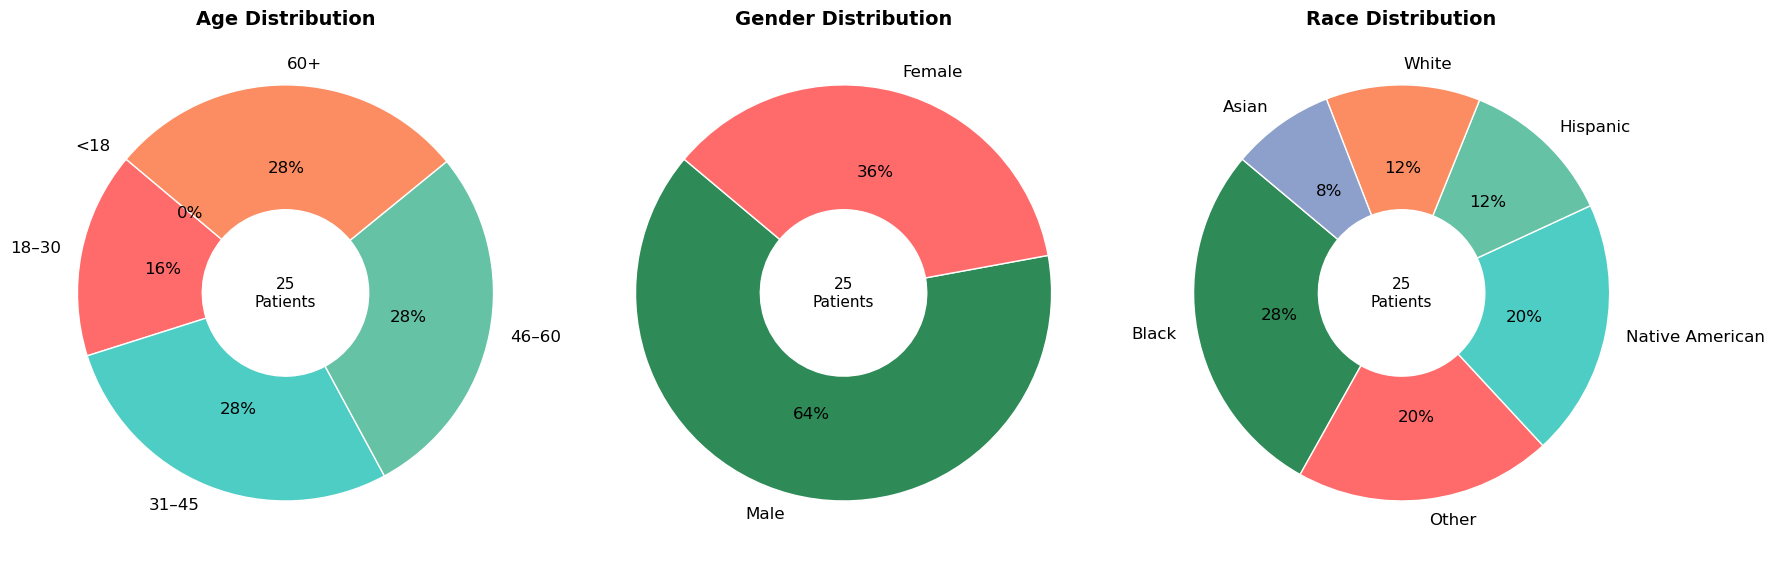

In [5]:
total_patients = len(df_demographics)

age_groups = pd.cut(df_demographics['age'], 
                    bins=[0, 18, 30, 45, 60, 100], 
                    labels=['<18', '18–30', '31–45', '46–60', '60+'])

age_dist = age_groups.value_counts().sort_index()
gender_dist = df_demographics['gender'].value_counts()
race_dist = df_demographics['race'].value_counts()

print(f"Total Patients: {total_patients}")
print("\nAge Distribution:\n", age_dist)
print("\nGender Distribution:\n", gender_dist)
print("\nRace Distribution:\n", race_dist)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
distributions = [age_dist, gender_dist, race_dist]
titles = ['Age Distribution', 'Gender Distribution', 'Race Distribution']
color_set = ['#2E8B57', '#FF6B6B', '#4ECDC4','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

for ax, dist, title in zip(axes, distributions, titles):
    wedges, texts, autotexts = ax.pie(dist, 
                                      labels=dist.index, 
                                      autopct='%1.0f%%', 
                                      startangle=140,
                                      colors=color_set,
                                      wedgeprops={'width': 0.6, 'edgecolor': 'white'},
                                      textprops={'fontsize': 12})
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.text(0, 0, f'{total_patients}\nPatients', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

## Sleep duration and quality by age group

In [190]:
age_groups = pd.cut(df_demographics['age'],bins=[0, 18, 30, 45, 60, 100],labels=['<18', '18–30', '31–45', '46–60', '60+'])

sleep_by_age_group = df_demographics.groupby(age_groups, observed=False)['avg_sleep_duration_hrs'].mean().round(2).reset_index()
sleep_by_age_group.columns = ['Age Group', 'Avg Sleep(hrs)']

print(sleep_by_age_group.to_string(index=False))

Age Group  Avg Sleep(hrs)
      <18             NaN
    18–30            6.02
    31–45            6.30
    46–60            5.79
      60+            5.80


## Distribution of sleep quality ratings

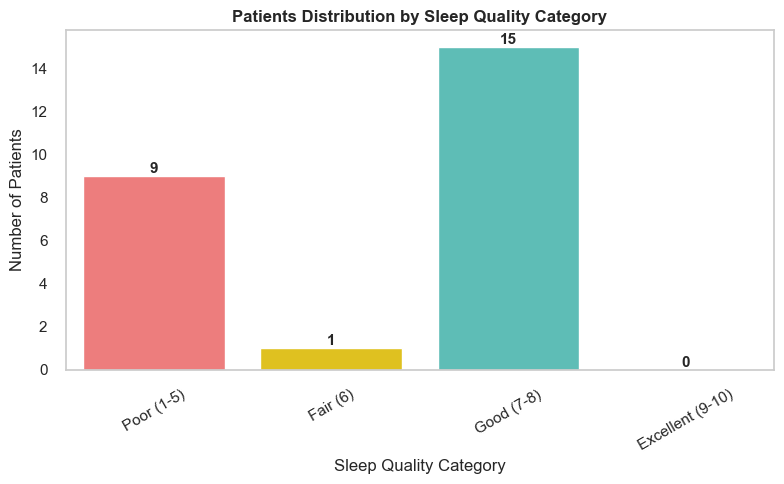

In [191]:
def categorize_sleep_quality(rating):
    if rating <= 5:
        return 'Poor (1-5)'
    elif rating == 6:
        return 'Fair (6)'
    elif rating <= 8:
        return 'Good (7-8)'
    else:
        return 'Excellent (9-10)'

df_demographics['Quality_Category'] = df_demographics['sleep_quality'].apply(categorize_sleep_quality)
category_dist = df_demographics['Quality_Category'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df_demographics, 
    x='Quality_Category', 
    order=['Poor (1-5)', 'Fair (6)', 'Good (7-8)', 'Excellent (9-10)'],
    palette=['#FF6B6B', '#FFD700', '#4ECDC4', '#2E8B57']
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',  
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')
plt.title('Patients Distribution by Sleep Quality Category', fontweight='bold')
plt.xlabel('Sleep Quality Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=30)
plt.grid(False)
plt.tight_layout()
plt.show()


## Relationship between sleep disturbances and sleep quality

Pearson correlation: -0.04 (p-value = 0.8570)


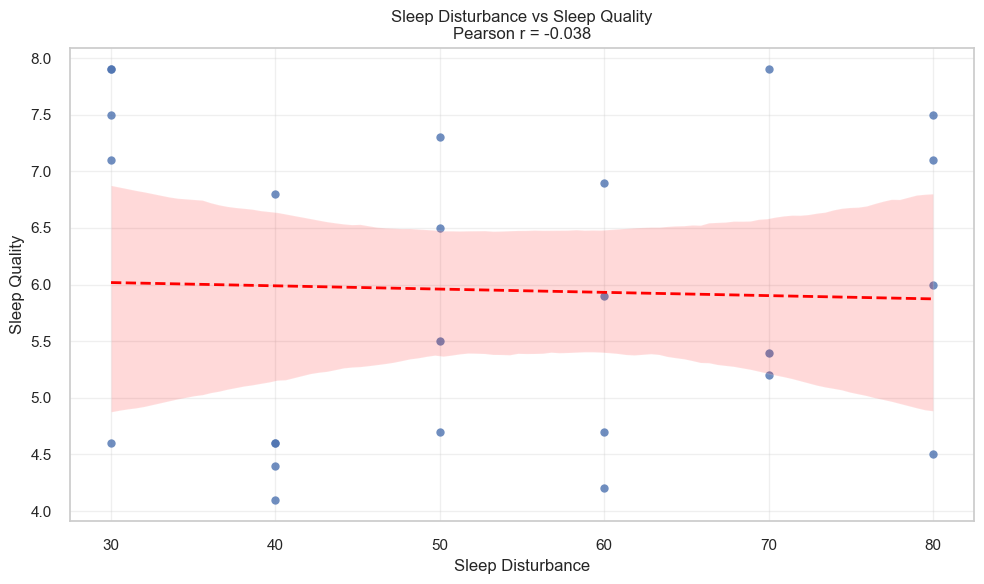

In [192]:
pearson_corr, pearson_p =stats.pearsonr(df_demographics['sleep_disturbance_%'], df_demographics['sleep_quality'])
print(f'Pearson correlation: {pearson_corr:.2f} (p-value = {pearson_p:.4f})')

plt.figure(figsize=(10, 6))
sns.regplot(data=df_demographics, 
           x='sleep_disturbance_%', 
           y='sleep_quality',
           line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2})

plt.title(f'Sleep Disturbance vs Sleep Quality\nPearson r = {pearson_corr:.3f}')
plt.xlabel('Sleep Disturbance')
plt.ylabel('Sleep Quality')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Associations between sleep, carbohydrates, and glucose irregularities

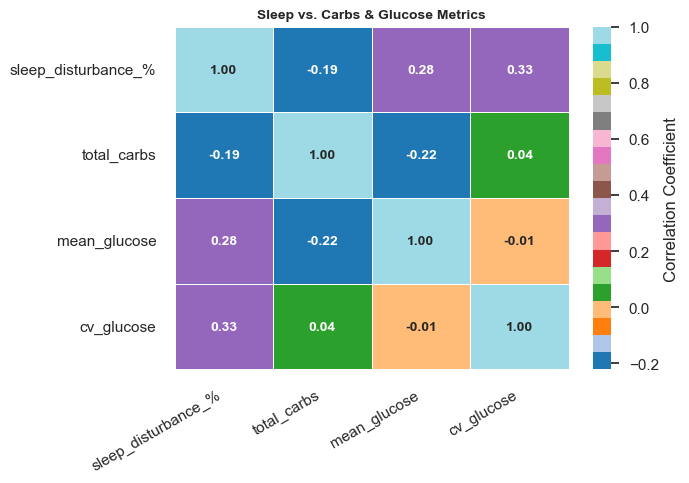

In [193]:
gluc_carb = (df_diabetes.groupby("patient_id").agg(total_carbs=("carb_input", "sum"), avg_carbs=("carb_input", "mean"),
        mean_glucose=("glucose", "mean"), std_glucose=("glucose", "std")).reset_index())

gluc_carb["cv_glucose"] = (gluc_carb["std_glucose"] / gluc_carb["mean_glucose"] * 100)
sleep = gluc_carb.merge(df_demographics, on="patient_id", how="left")
corr = sleep[["sleep_disturbance_%", "total_carbs", "mean_glucose", "cv_glucose"]].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="tab20",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)
plt.title("Sleep vs. Carbs & Glucose Metrics", fontsize=10, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Glucose level distribution among patients

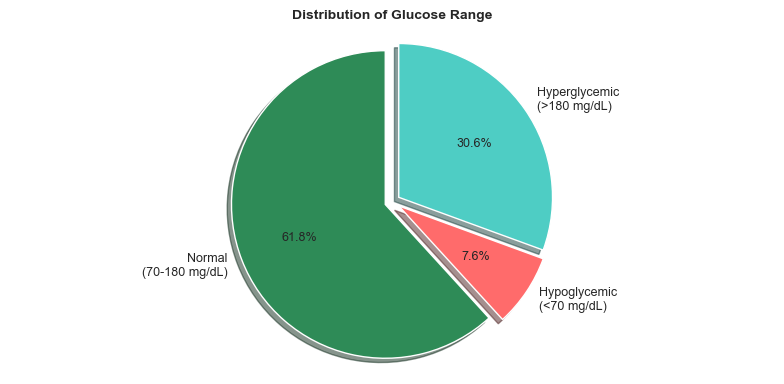

In [194]:
normal = (df_diabetes['glucose'] >= 70) & (df_diabetes['glucose'] <= 180)
hypo = df_diabetes['glucose'] < 70
hyper = df_diabetes['glucose'] > 180

normal_per = (normal.sum() / len(df_diabetes)) * 100
hypo_per = (hypo.sum() / len(df_diabetes)) * 100
hyper_per = (hyper.sum() / len(df_diabetes)) * 100

# Pie Chart
plt.figure(figsize=(8, 4))
labels = ['Normal\n(70-180 mg/dL)', 'Hypoglycemic\n(<70 mg/dL)', 'Hyperglycemic\n(>180 mg/dL)']
sizes = [normal_per, hypo_per, hyper_per]
colors = ['#2E8B57', '#FF6B6B', '#4ECDC4'] 
explode = (0.05, 0.05, 0.05)  

wedges, texts, autotexts = plt.pie(sizes, 
                                  labels=labels, 
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  explode=explode,
                                  shadow=True,
                                  startangle=90,
                                  textprops={'fontsize': 9})

plt.title('Distribution of Glucose Range', 
          fontsize=10, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


## Impact of carbohydrate intake on glucose levels


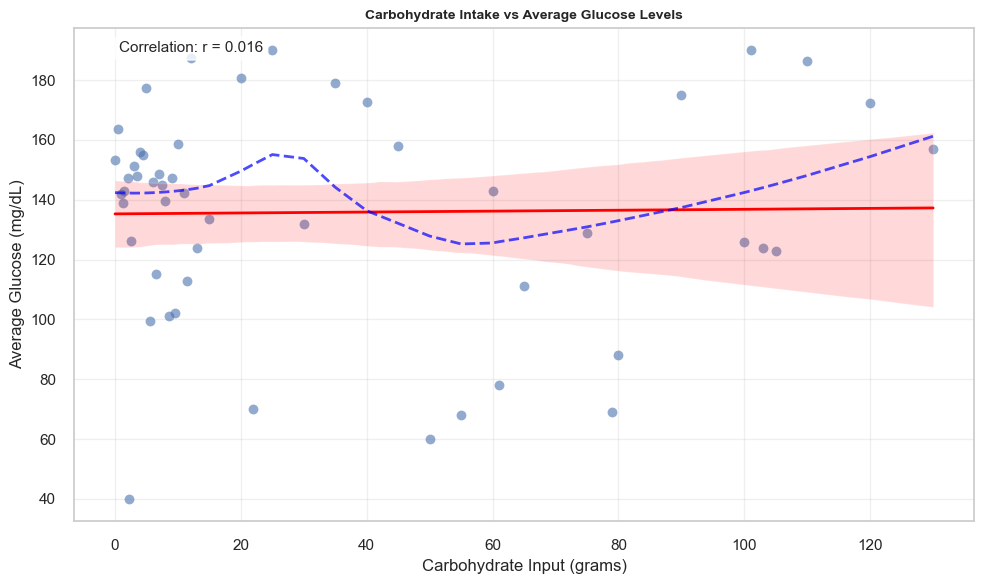

In [195]:
diabetes_copy = df_diabetes.copy()
diabetes_copy["timestamp"] = pd.to_datetime(df_diabetes["date"].astype(str) + " " + df_diabetes["time"].astype(str),errors="coerce")

df_grouped = (diabetes_copy.groupby("carb_input")["glucose"]
              .mean()
              .reset_index()
              .sort_values("carb_input"))
df_grouped = df_grouped.dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=df_grouped, 
           x="carb_input", 
           y="glucose", 
           scatter_kws={'alpha': 0.6, 's': 50},
           line_kws={"color": "red", "lw": 2})
sns.regplot(data=df_grouped, 
           x="carb_input", 
           y="glucose", 
           scatter=False,
           lowess=True,
           line_kws={"color": "blue", "lw": 2, "linestyle": "--", "alpha": 0.7})

plt.title("Carbohydrate Intake vs Average Glucose Levels", fontsize=10, fontweight='bold')
plt.xlabel("Carbohydrate Input (grams)", fontsize=12)
plt.ylabel("Average Glucose (mg/dL)", fontsize=12)
plt.grid(True, alpha=0.3)

correlation = df_grouped['carb_input'].corr(df_grouped['glucose'])
plt.text(0.05, 0.95, f'Correlation: r = {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
         fontsize=11)
plt.tight_layout()
plt.show()


## Basal-to-bolus insulin ratio and glucose stability


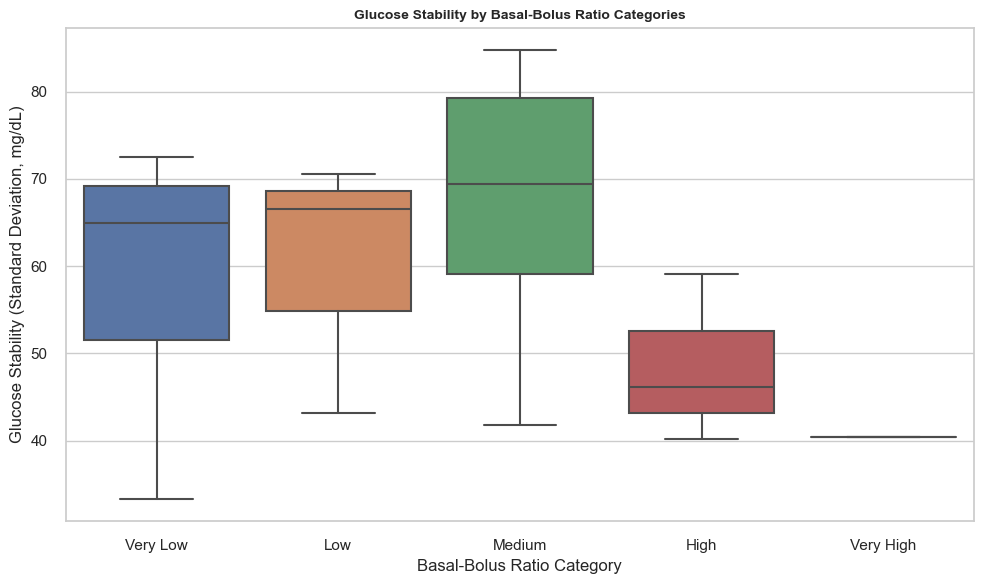


Total patients analyzed: 25
Overall correlation: -0.019


In [196]:
df_diabetes['basal_bolus_ratio'] = df_diabetes['basal_rate'] / (df_diabetes['insulin_bolus'] + 0.01)
glucose_stability = df_diabetes.groupby('patient_id')['glucose'].std().reset_index()
glucose_stability.columns = ['patient_id', 'glucose_stability']
avg_ratio = df_diabetes.groupby('patient_id')['basal_bolus_ratio'].mean().reset_index()
analysis = avg_ratio.merge(glucose_stability, on='patient_id')

analysis['ratio_category'] = pd.cut(analysis['basal_bolus_ratio'], 
                                      bins=5, 
                                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=analysis.dropna(), x='ratio_category', y='glucose_stability')
plt.title('Glucose Stability by Basal-Bolus Ratio Categories',fontsize=10, fontweight='bold')
plt.xlabel('Basal-Bolus Ratio Category', fontsize=12)
plt.ylabel('Glucose Stability (Standard Deviation, mg/dL)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTotal patients analyzed: {len(analysis_df)}")
correlation = analysis_df['basal_bolus_ratio'].corr(analysis_df['glucose_stability'])
print(f"Overall correlation: {correlation:.3f}")



## Identification of lifestyle and clinicalpredictors of hyperglycemia


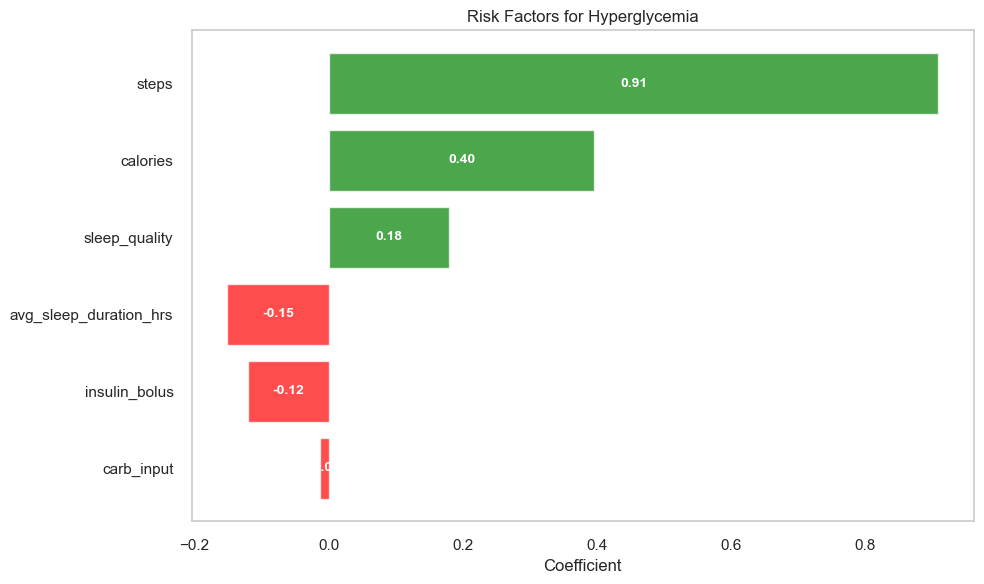

In [199]:
df_diabetes["hyperglycemia"] = (df_diabetes["glucose"] > 180).astype(int)

features = df_diabetes.groupby("patient_id").agg({
    "glucose": "mean",
    "calories": "mean", 
    "steps": "mean",
    "carb_input": "mean",
    "insulin_bolus": "mean",
    "hyperglycemia": "mean"
}).reset_index()

df_merged = features.merge(df_demographics[["patient_id", "avg_sleep_duration_hrs", "sleep_quality"]],
    on="patient_id", how="left")
df_merged["high_hyperglycemia"] = (df_merged["hyperglycemia"] > 0.3).astype(int)

x = df_merged[["avg_sleep_duration_hrs", "sleep_quality", "steps","calories", "carb_input", "insulin_bolus"]]
y = df_merged["high_hyperglycemia"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
model = LogisticRegression(random_state=42)
model.fit(x_scaled, y)

importance = pd.DataFrame({ "Feature": X.columns,
                            "Coefficient": model.coef_[0]}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in importance['Coefficient']]
bars = plt.barh(importance['Feature'], importance['Coefficient'], color=colors, alpha=0.7)

for i, (bar, (_, row)) in enumerate(zip(bars, importance.iterrows())):
    coef = row['Coefficient']
    x_pos = coef / 2 
    plt.text(x_pos, i, f'{coef:.2f}', ha='center', va='center',color='white', fontweight='bold', fontsize=10)
    
plt.xlabel('Coefficient')
plt.title('Risk Factors for Hyperglycemia')
plt.gca().invert_yaxis() 
plt.grid(False)
plt.tight_layout()
plt.show()


## Identification of patients with high basal but low bolus insulin delivery

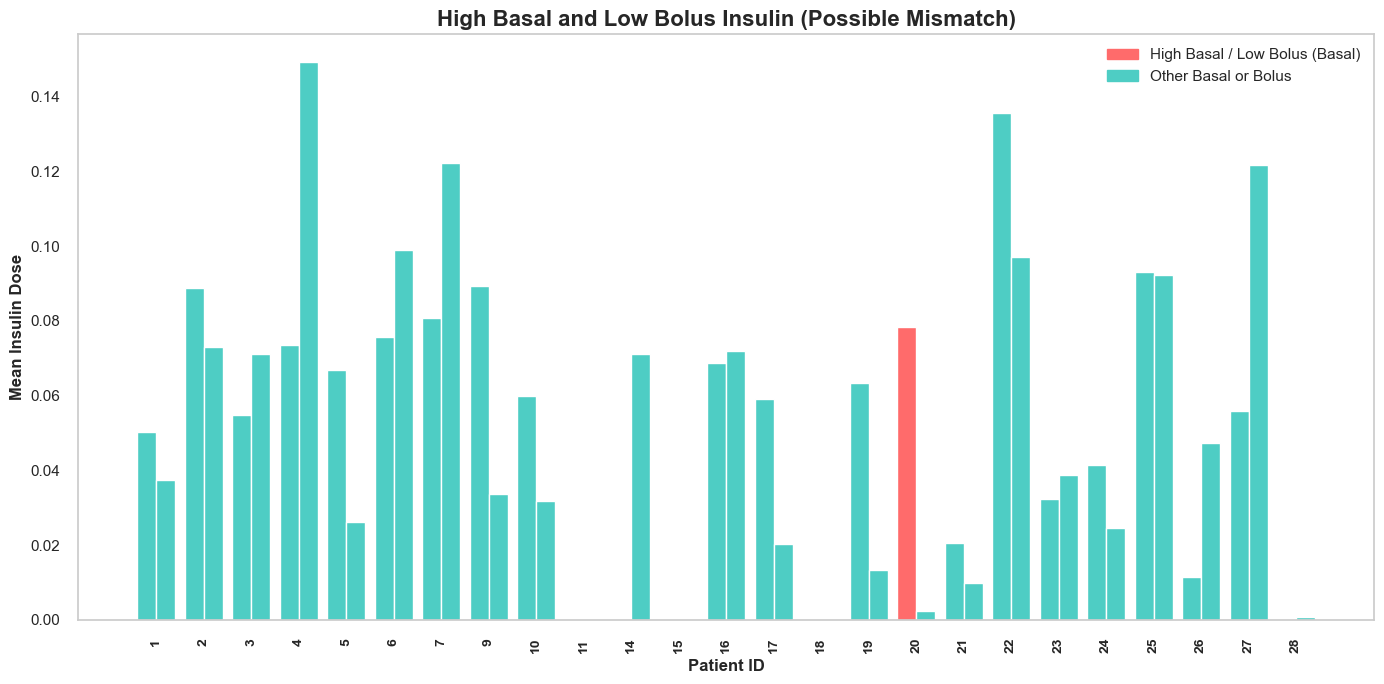

Total patients with mismatch: 1


In [200]:
insulin = df_diabetes.groupby('patient_id').agg({'basal_rate': 'mean','insulin_bolus': 'mean'}).reset_index()

basal_thresh = insulin['basal_rate'].quantile(0.75)
bolus_thresh = insulin['insulin_bolus'].quantile(0.25)
high_basal_low_bolus = insulin[(insulin['basal_rate'] > basal_thresh) & (insulin['insulin_bolus'] < bolus_thresh)]

plt.figure(figsize=(14, 7))

highlight = insulin_df['patient_id'].isin(high_basal_low_bolus['patient_id'])
index = range(len(insulin_df))
bar_width = 0.4

colors_basal = ['#FF6B6B' if h else '#4ECDC4' for h in highlight]   
colors_bolus = ['#4ECDC4' if h else '#4ECDC4' for h in highlight] 

plt.bar([i - bar_width/2 for i in index], insulin_df['basal_rate'], bar_width, color=colors_basal)
plt.bar([i + bar_width/2 for i in index], insulin_df['insulin_bolus'], bar_width, color=colors_bolus)

plt.xticks(index, insulin_df['patient_id'].astype(str), rotation=90, fontsize=10, fontweight='bold')
plt.xlabel('Patient ID', fontsize=12, fontweight='bold')
plt.ylabel('Mean Insulin Dose', fontsize=12, fontweight='bold')
plt.title('High Basal and Low Bolus Insulin (Possible Mismatch)', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

legend_patches = [
    mpatches.Patch(color='#FF6B6B', label='High Basal / Low Bolus (Basal)'),
    mpatches.Patch(color='#4ECDC4', label='Other Basal or Bolus'),
]
plt.legend(handles=legend_patches, fontsize=11)
plt.grid(False)
plt.tight_layout()
plt.show()

print(f"Total patients with mismatch: {len(high_basal_low_bolus)}")

## Combining poor sleep quality and high carbohydrate intake to flag high-risk patients.

Sleep Quality Threshold (Poor Sleep): ≤ 4.6
Carb Intake Threshold (High Carb): ≥ 0.1g


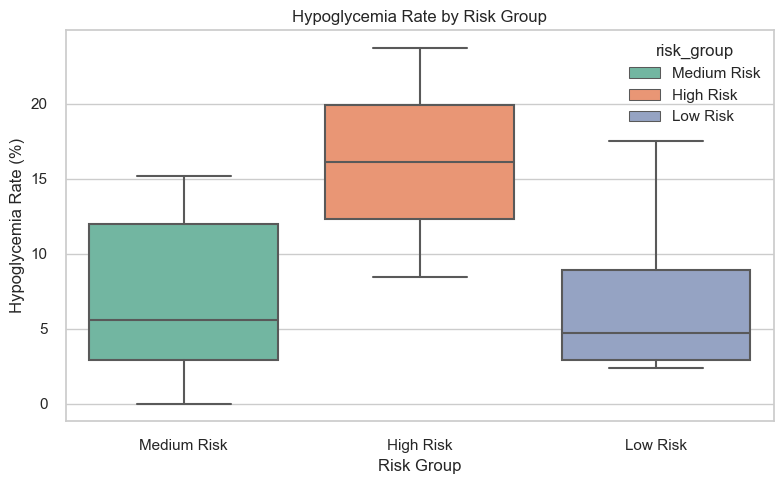


RECOMMENDATION: YES — Combining poor sleep + high carb intake identifies high-risk patients.


In [180]:
carb_intake = df_diabetes.groupby('patient_id')['carb_input'].mean().reset_index(name='avg_carb_intake')
hypo_counts = df_diabetes.groupby('patient_id')['glucose'].apply(lambda x: (x < 70).sum()).reset_index(name='hypoglycemia_count')
total_readings = df_diabetes.groupby('patient_id').size().reset_index(name='total_readings')

risk_analysis = df_demographics[['patient_id', 'sleep_quality']].merge(carb_intake, on='patient_id', how='left') \
                                                           .merge(hypo_counts, on='patient_id', how='left') \
                                                           .merge(total_readings, on='patient_id', how='left')

risk_analysis['hypoglycemia_rate'] = (risk_analysis['hypoglycemia_count'] / risk_analysis['total_readings']) * 100

sleep_threshold = risk_analysis['sleep_quality'].quantile(0.25)
carb_threshold = risk_analysis['avg_carb_intake'].quantile(0.75)

print(f"Sleep Quality Threshold (Poor Sleep): ≤ {sleep_threshold:.1f}")
print(f"Carb Intake Threshold (High Carb): ≥ {carb_threshold:.1f}g")

risk_analysis['poor_sleep'] = risk_analysis['sleep_quality'] <= sleep_threshold
risk_analysis['high_carb'] = risk_analysis['avg_carb_intake'] >= carb_threshold

def assign_risk(row):
    if row['poor_sleep'] and row['high_carb']:
        return 'High Risk'
    elif row['poor_sleep'] or row['high_carb']:
        return 'Medium Risk'
    else:
        return 'Low Risk'

risk_analysis['risk_group'] = risk_analysis.apply(assign_risk, axis=1)

# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=risk_analysis,x='risk_group', y='hypoglycemia_rate', hue='risk_group',  dodge=False, 
    palette='Set2')

plt.title('Hypoglycemia Rate by Risk Group')
plt.xlabel('Risk Group')
plt.ylabel('Hypoglycemia Rate (%)')
plt.tight_layout()
plt.show()

# Clinical recommendation based on t-test and mean difference
high_risk = risk_analysis[risk_analysis['risk_group'] == 'High Risk']['hypoglycemia_rate']
low_risk = risk_analysis[risk_analysis['risk_group'] == 'Low Risk']['hypoglycemia_rate']

if len(high_risk) > 0 and len(low_risk) > 0:
    t_stat, p_value = stats.ttest_ind(high_risk, low_risk)
    
    if p_value < 0.05 and high_risk.mean() > low_risk.mean():
        print("\nRECOMMENDATION: YES — Combining poor sleep + high carb intake identifies high-risk patients.")
    elif high_risk.mean() > low_risk.mean() * 1.5:
        print("\nRECOMMENDATION: CONSIDER — There's a clinical difference worth further exploration.")
    else:
        print("\nRECOMMENDATION: NOT SUPPORTED — The combination does not significantly improve risk identification.")
else:
    print("\nInsufficient data for t-test.")

## Prioritization of Sleep Interventions for Glycemic Control


TOP 5 PRIORITY PATIENTS AND RECOMMENDATIONS:

Patient 1:
  Priority Score: 0.80
  Recommendations: Increase sleep duration; Reduce sleep disturbances; Monitor glucose more closely

Patient 14:
  Priority Score: 0.74
  Recommendations: Increase sleep duration; Monitor glucose more closely

Patient 6:
  Priority Score: 0.73
  Recommendations: Reduce sleep disturbances; Monitor glucose more closely

Patient 9:
  Priority Score: 0.70
  Recommendations: Reduce sleep disturbances; Monitor glucose more closely

Patient 4:
  Priority Score: 0.69
  Recommendations: Increase sleep duration; Reduce sleep disturbances; Monitor glucose more closely


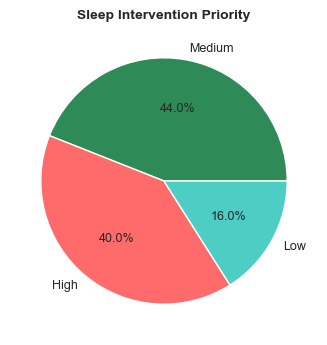

In [204]:
def prioritize_sleep_interventions(df_demographics, merged_df):
    glucose_stats = df_diabetes.groupby('patient_id')['glucose'].agg(['mean', 'std']).reset_index()
    glucose_stats.columns = ['patient_id', 'avg_glucose', 'glucose_std']
    
    df = df_demographics.merge(glucose_stats, on='patient_id', how='inner')
    
    df['sleep_quality_norm'] = (df['sleep_quality'].max() - df['sleep_quality']) / (df['sleep_quality'].max() - df['sleep_quality'].min())
    df['disturbance_norm'] = df['sleep_disturbance_%'] / 100
    df['short_sleep_norm'] = np.where(df['avg_sleep_duration_hrs'] < 7, (7 - df['avg_sleep_duration_hrs']) / 3, 0)
    df['high_glucose_norm'] = np.where(df['avg_glucose'] > 140, (df['avg_glucose'] - 140) / df['avg_glucose'].std(), 0)
    df['variability_norm'] = (df['glucose_std'] - df['glucose_std'].min()) / (df['glucose_std'].max() - df['glucose_std'].min())
    
    #  priority score
    df['priority_score'] = (
        df['sleep_quality_norm'] * 0.3 +
        df['disturbance_norm'] * 0.2 +
        df['short_sleep_norm'] * 0.2 +
        df['high_glucose_norm'] * 0.15 +
        df['variability_norm'] * 0.15
    )
    
    return df.sort_values('priority_score', ascending=False)

priority_df = prioritize_sleep_interventions(df_demographics,df_diabetes)

# Plot 
plt.figure(figsize=(8, 4))
priority_counts = pd.cut(priority_df['priority_score'], bins=3, labels=['Low', 'Medium', 'High']).value_counts()
priority_counts.plot.pie(autopct='%1.1f%%', colors=['#2E8B57', '#FF6B6B', '#4ECDC4'], ylabel='',textprops={'fontsize': 9})
plt.title('Sleep Intervention Priority', 
          fontsize=10, fontweight='bold')

# Top 5 Recommendations
def recommend(row):
    recs = []
    if row['avg_sleep_duration_hrs'] < 6.5:
        recs.append("Increase sleep duration")
    if row['sleep_disturbance_%'] > 30:
        recs.append("Reduce sleep disturbances")
    if row['sleep_quality'] < 3:
        recs.append("Improve sleep quality")
    if row['avg_glucose'] > 150:
        recs.append("Monitor glucose more closely")
    return "; ".join(recs)

print("\nTOP 5 PRIORITY PATIENTS AND RECOMMENDATIONS:")
for _, row in priority_df.head(5).iterrows():
    print(f"\nPatient {int(row['patient_id'])}:")
    print(f"  Priority Score: {row['priority_score']:.2f}")
    print(f"  Recommendations: {recommend(row)}")
